In [0]:
import tensorflow as tf
from tensorflow.keras import layers
from PIL import Image
import os
import pathlib
import numpy as np
import pathlib
import shutil
from matplotlib import pyplot as plt

In [0]:
BASE_PATH = '/dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0330'
DATA_PATH = '/dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/Pictures'
# train_dir = pathlib.Path(DATA_PATH+'/training')
# val_dir = pathlib.Path(DATA_PATH+'/val')

# train_dir = dbutils.fs.ls(DATA_PATH+"/train/")
# val_dir = dbutils.fs.ls(DATA_PATH+"/val/")
batch_size = 128
img_height = 120
img_width = 160

resized_height = 120
resized_width = 160

# IMG_SHAPE = (224, 224, 3)
# CLASS_PEOPLE = "/dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/training/people_class"
num_classes = 2
NUM_EPOCHS = 120
seed = 12
log_dir = BASE_PATH + "/logs"

STEPS_PER_EPOCH = 1508 //batch_size

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
data_augmentation = tf.keras.Sequential([
#   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
#   layers.experimental.preprocessing.RandomContrast(0.2),
])

resize = tf.keras.layers.experimental.preprocessing.Resizing(resized_height, resized_width)

def preprocess_input(image):
    return (image/127.5) - 1

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_PATH,
  seed=seed,
  shuffle=True,
  validation_split=0.2,
  subset='training',
  image_size=(img_height, img_width)
)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

train_ds = train_ds.map(
  lambda x, y: (preprocess_input(x), y))


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_PATH,
  seed=seed,
  shuffle=True,
  validation_split=0.2,
  subset='validation',
  image_size=(img_height, img_width)
)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(
  lambda x, y: (preprocess_input(x), y))

Found 11163 files belonging to 2 classes.
Using 8931 files for training.
Found 11163 files belonging to 2 classes.
Using 2232 files for validation.

In [0]:
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (10, 0.005),
    (30, 0.001),
    (50, 0.0005)
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

In [0]:
base_lr , alpha =0.001 , 0.35
def get_model(lr=base_lr, alpha=alpha,trainable = False):
  base_model = tf.keras.applications.MobileNetV2(
      input_shape=(img_height, img_width, 3),
      include_top=False, weights='imagenet', alpha=alpha)
#     base_model.trainable = False
  base_model.trainable = trainable
  x = base_model.output
  # Add a new classifier layer for transfer learning
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
  #     prediction_layer = tf.keras.layers.Dense(1, activation='softmax')
  model = tf.keras.Model(inputs=base_model.inputs, outputs=x)
  return model


def initial_trainning_model(lr=base_lr,trainable = False):
  model = get_model(trainable = trainable)
  model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
  return model


def fine_tuning(lr=base_lr,trainable = True):
  model = get_model(trainable = trainable)
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_lr/10),
              metrics=['accuracy'])
  return model

In [0]:
initial_epochs = 90
fine_tune_epochs = 90
total_epochs =  initial_epochs + fine_tune_epochs

# call backs
checkpoint_path = BASE_PATH + "/Model/Best_Model2.h5py"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                               save_weights_only= False,
                                               save_best_only = True,
                                               monitor='accuracy',
                                               mode='auto', 
                                               save_freq='epoch',
                                               verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)


In [0]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
      print('yes')
#     tf.config.experimental.set_virtual_device_configuration(
#         gpus[0],
#         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
yes
yes
2 Physical GPUs, 2 Logical GPUs

In [0]:
# initial training
tf.debugging.set_log_device_placement(True)
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
  model = initial_trainning_model()
  print(model.summary())
  history = model.fit(train_ds,
                      epochs=initial_epochs,
                      validation_data=val_ds,
                      verbose=2,
                     callbacks=[cp_callback, early_stop]
                     )
  

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
WARNING:tensorflow:`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "functional_13"
__________________________________________________________________________________________________
Layer (type) Output Shape Param # Connected to 
==================================================================================================
input_7 (InputLayer) [(None, 120, 160, 3) 0 
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D) (None, 121, 161, 3) 0 input_7[0][0] 
__________________________________________________________________________________________________
Conv1 (Conv2D) (None, 60, 80, 16) 432 Conv1_pad[0][0] 
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization) (None, 60, 80, 16) 64 Conv1[0][0] 
__________________________________________________________________________________________________
Conv1_relu (ReLU) (None, 60, 80, 16) 0 bn_Conv1[0][0] 
__________________________________________________________________________________________________
expanded_conv_depthwise (Depthw (None, 60, 80, 16) 144 Conv1_relu[0][0] 
__________________________________________________________________________________________________
expanded_conv_depthwise_BN (Bat (None, 60, 80, 16) 64 expanded_conv_depthwise[0][0] 
__________________________________________________________________________________________________
expanded_conv_depthwise_relu (R (None, 60, 80, 16) 0 expanded_conv_depthwise_BN[0][0] 
__________________________________________________________________________________________________
expanded_conv_project (Conv2D) (None, 60, 80, 8) 128 expanded_conv_depthwise_relu[0][0
__________________________________________________________________________________________________
expanded_conv_project_BN (Batch (None, 60, 80, 8) 32 expanded_conv_project[0][0] 
__________________________________________________________________________________________________
block_1_expand (Conv2D) (None, 60, 80, 48) 384 expanded_conv_project_BN[0][0] 
__________________________________________________________________________________________________
block_1_expand_BN (BatchNormali (None, 60, 80, 48) 192 block_1_expand[0][0] 
___________________________________________________________________

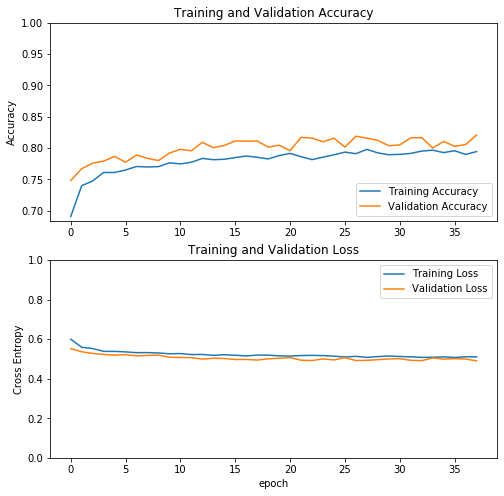

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
# fine-tuning

with strategy.scope():
  model = fine_tuning()
  print(model.summary())
  history_fine = model.fit(train_ds,
                           epochs=total_epochs,
                           initial_epoch=history.epoch[-1],
                            validation_data=val_ds,
                            verbose=2,
                           callbacks=[cp_callback, early_stop]
                     )

WARNING:tensorflow:`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
Model: "functional_23"
__________________________________________________________________________________________________
Layer (type) Output Shape Param # Connected to 
==================================================================================================
input_12 (InputLayer) [(None, 120, 160, 3) 0 
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D) (None, 121, 161, 3) 0 input_12[0][0] 
__________________________________________________________________________________________________
Conv1 (Conv2D) (None, 60, 80, 16) 432 Conv1_pad[0][0] 
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization) (None, 60, 80, 16) 64 Conv1[0][0] 
__________________________________________________________________________________________________
Conv1_relu (ReLU) (None, 60, 80, 16) 0 bn_Conv1[0][0] 
__________________________________________________________________________________________________
expanded_conv_depthwise (Depthw (None, 60, 80, 16) 144 Conv1_relu[0][0] 
__________________________________________________________________________________________________
expanded_conv_depthwise_BN (Bat (None, 60, 80, 16) 64 expanded_conv_depthwise[0][0] 
__________________________________________________________________________________________________
expanded_conv_depthwise_relu (R (None, 60, 80, 16) 0 expanded_conv_depthwise_BN[0][0] 
__________________________________________________________________________________________________
expanded_conv_project (Conv2D) (None, 60, 80, 8) 128 expanded_conv_depthwise_relu[0][0
__________________________________________________________________________________________________
expanded_conv_project_BN (Batch (None, 60, 80, 8) 32 expanded_conv_project[0][0] 
__________________________________________________________________________________________________
block_1_expand (Conv2D) (None, 60, 80, 48) 384 expanded_conv_project_BN[0][0] 
__________________________________________________________________________________________________
block_1_expand_BN (BatchNormali (None, 60, 80, 48) 192 block_1_expand[0][0] 
__________________________________________________________________________________________________
block_1_expand_relu (ReLU) (None, 60, 80, 48) 0 block_1_expand_BN[0][0] 
__________________________________________________________________________________________________
block_1_pad (ZeroPadding2D) (None, 61, 81, 48) 0 block_1_expand_relu[0][0] 
__________________________________________________________________________________________________
block_1_depthwise (DepthwiseCon (None, 30, 40, 48) 432 block_1_pad[0][0] 
__________________________________________________________________________________________________
block_1_depthwise_BN (BatchNorm (None, 30, 40, 48) 192 block_1_depthwise[0][0] 
__________________________________________________________________________________________________
block_1_depthwise_relu (ReLU) (None, 30, 40, 48) 0 block_1_depthwise_BN[0][0] 
__________________________________________________________________________________________________
block_1_project (Conv2D) (None, 30, 40, 8) 384 block_1_depthwise_relu[0][0] 
__________________________________________________________________________________________________
block_1_project_BN (BatchNormal (None, 30, 40, 8) 32 block_1_project[0][0] 
__________________________________________________________________________________________________
block_2_expand (Conv2D) (None, 30, 40, 48) 384 block_1_project_BN[0][0] 
__________________________________________________________________________________________________
block_2_expand_BN (BatchNormali (None, 30, 40, 48) 192 block_2_expand[0][0] 
______________________________________

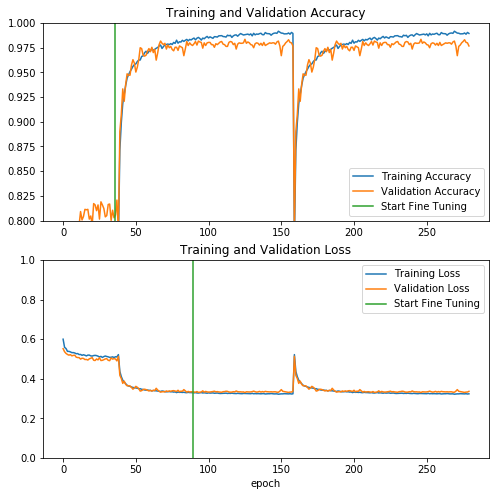

In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([history.epoch[-1]-1,history.epoch[-1]-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
# model.save(BASE_PATH + '/Model/Best_Model')

In [0]:
# !tar -cvf /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0325/Model/Best_Model.tar /dbfs/FileStore/shared_uploads/wu.wenjun@otis.com/0325/Model/Best_Model